In [1]:
#initialise

import extractor
fps, resolution = extractor.run('input_videos/input.mp4')






Taking input input_videos/input.mp4
FPS: 30.0
Resolution: 720x720
Audio extracted to output_data/audio.mp3
Extracted 661 frames.
Feature data has been collected!
Writing data to csv
Features saved to output_data/output_features.csv
Extraction completed!


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  




In [3]:
# config:
unbiased = True # Should data be shuffled before training. Biased data is more accurate with reconstruction of the original video.
feature_threshold = 0.3 # between 0 and 1, how much should the data correlate to the target variable? 1 is 1 to 1 and 0 is not at all

In [4]:
import pydub

df = pd.read_csv('output_data/output_features.csv')
df['frame_index'] = df.index
df['normalized_index']=df['frame_index']/len(df)

audio_full = pydub.AudioSegment.from_mp3('output_data/audio.mp3')

slice_paths = []

for i in range(len(df['timestamp'])):
    frame_start = df['timestamp'][i]
    if i >= len(df['timestamp'])-1:
        frame_end = len(audio_full)
    else:
        frame_end = df['timestamp'][(i+1)]
    slice:pydub.AudioSegment = audio_full[frame_start:frame_end]
    slice_path = f'output_slices/audio_slice_{frame_start*0.001}_{i}.wav'
    slice.export(slice_path, format='wav')
    slice_paths.append(slice_path)

    




df['audio_slice_path'] = slice_paths
if unbiased:
    df = df.sample(frac=1.0,random_state=42).reset_index(drop=True)
print(df[['frame_filename','frame_index','normalized_index','audio_slice_path']].head())

                         frame_filename  frame_index  normalized_index  \
0   output_frames/frame_17_time_566.jpg           17          0.459459   
1   output_frames/frame_13_time_433.jpg           13          0.351351   
2    output_frames/frame_4_time_133.jpg            4          0.108108   
3   output_frames/frame_29_time_966.jpg           29          0.783784   
4  output_frames/frame_35_time_1166.jpg           35          0.945946   

                                    audio_slice_path  
0  output_slices/audio_slice_0.5660000000000001_1...  
1             output_slices/audio_slice_0.433_13.wav  
2              output_slices/audio_slice_0.133_4.wav  
3             output_slices/audio_slice_0.966_29.wav  
4             output_slices/audio_slice_1.166_35.wav  


In [5]:
# Check shape
print("DataFrame shape:", df.shape)

# Check first few rows
print(df.head())



# Check if you accidentally only have one row
if df.shape[0] <= 1:
    print("Warning: Only 1 row detected!")

#df = df[df != 0] # remove redundant parameters
# Check for missing rows or NaNs
df = df.loc[:,(df != 0).any(axis=0)]
print(df.isnull().sum())



DataFrame shape: (37, 1517)
   timestamp                        frame_filename  hist_bin_0  hist_bin_1  \
0        566   output_frames/frame_17_time_566.jpg    0.054580    0.060911   
1        433   output_frames/frame_13_time_433.jpg    0.551096    0.396885   
2        133    output_frames/frame_4_time_133.jpg    0.564591    0.394590   
3        966   output_frames/frame_29_time_966.jpg    0.008864    0.019402   
4       1166  output_frames/frame_35_time_1166.jpg    0.396609    0.569951   

   hist_bin_2  hist_bin_3  hist_bin_4  hist_bin_5  hist_bin_6  hist_bin_7  \
0    0.029178    0.118794    0.000918    0.000642    0.000052         0.0   
1    0.050388    0.041175    0.095306    0.051482    0.000000         0.0   
2    0.043223    0.026429    0.077938    0.044473    0.000000         0.0   
3    0.011097    0.045694    0.023596    0.000123    0.000000         0.0   
4    0.046875    0.019666    0.033150    0.040851    0.022814         0.0   

   ...  edge_993  edge_994  edge_995  ed

In [6]:
#Correlation test
numerical_df = df.select_dtypes(include=['float64','int64'])



corr_matrix = numerical_df.corr()
normalized_index_corr = corr_matrix['normalized_index'].sort_values(ascending=False)
normalized_index_corr = normalized_index_corr.drop(['normalized_index','timestamp','frame_index'])
print(normalized_index_corr)

hist_bin_149    0.901153
hist_bin_76     0.863053
hist_bin_302    0.853637
hist_bin_291    0.833212
hist_bin_290    0.794070
                  ...   
hist_bin_19    -0.841510
hist_bin_16    -0.843051
hist_bin_247   -0.845269
hist_bin_239   -0.845463
hist_bin_174   -0.848694
Name: normalized_index, Length: 742, dtype: float64


In [7]:

X = df.drop(['timestamp','frame_filename','frame_index','normalized_index','audio_slice_path'], axis=1)
y = df['normalized_index']

In [8]:
# get strong features
strong_features = normalized_index_corr[abs(normalized_index_corr) > feature_threshold].index.to_list()
print(strong_features)
X = X[strong_features]

['hist_bin_149', 'hist_bin_76', 'hist_bin_302', 'hist_bin_291', 'hist_bin_290', 'hist_bin_374', 'hist_bin_411', 'hist_bin_294', 'hist_bin_229', 'hist_bin_367', 'hist_bin_439', 'hist_bin_301', 'hist_bin_192', 'hist_bin_212', 'hist_bin_226', 'hist_bin_67', 'hist_bin_139', 'hist_bin_66', 'hist_bin_140', 'hist_bin_503', 'hist_bin_375', 'hist_bin_366', 'hist_bin_361', 'hist_bin_293', 'hist_bin_430', 'hist_bin_357', 'hist_bin_218', 'hist_bin_221', 'hist_bin_403', 'hist_bin_203', 'hist_bin_285', 'hist_bin_438', 'hist_bin_276', 'hist_bin_228', 'hist_bin_345', 'hist_bin_222', 'hist_bin_148', 'hist_bin_220', 'hist_bin_358', 'hist_bin_364', 'hist_bin_365', 'hist_bin_211', 'hist_bin_137', 'hist_bin_129', 'hist_bin_412', 'hist_bin_156', 'hist_bin_498', 'hist_bin_284', 'hist_bin_494', 'hist_bin_147', 'hist_bin_77', 'hist_bin_429', 'hist_bin_349', 'hist_bin_154', 'hist_bin_138', 'hist_bin_217', 'hist_bin_421', 'hist_bin_355', 'hist_bin_356', 'hist_bin_292', 'hist_bin_193', 'hist_bin_433', 'hist_bin_4

In [9]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [10]:
y_pred = model.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 0.0159
R2 Score: 0.8585


In [12]:
df['predicted_normalized_index'] = model.predict(X)

# sort by predicted order
df_sorted = df.sort_values(by='predicted_normalized_index')

print(df_sorted[['frame_filename','predicted_normalized_index']].head(10))


                         frame_filename  predicted_normalized_index
16     output_frames/frame_0_time_0.jpg                    0.041622
20    output_frames/frame_1_time_33.jpg                    0.047027
23    output_frames/frame_2_time_66.jpg                    0.080811
2    output_frames/frame_4_time_133.jpg                    0.110541
26   output_frames/frame_3_time_100.jpg                    0.133784
18   output_frames/frame_5_time_166.jpg                    0.150811
6    output_frames/frame_6_time_200.jpg                    0.159189
34   output_frames/frame_7_time_233.jpg                    0.191892
10   output_frames/frame_8_time_266.jpg                    0.199730
30  output_frames/frame_10_time_333.jpg                    0.251892


In [13]:
import cv2

output_video = cv2.VideoWriter('output_data/reconstructed.avi',
                               cv2.VideoWriter_fourcc(*'XVID'),
                               fps,
                               resolution)  


for _, row in df_sorted.iterrows():
    frame = cv2.imread(row['frame_filename'])
    output_video.write(frame)

output_video.release()
print("Reconstructed Video Saved!!")

Reconstructed Video Saved!!


In [14]:
final_audio:pydub.AudioSegment = pydub.AudioSegment.empty()
for s in df_sorted['audio_slice_path']:
    sorted_slice = pydub.AudioSegment.from_wav(s)
    final_audio = final_audio.append(sorted_slice, crossfade=0)
final_audio.export('output_data/final_audio.mp3')

<_io.BufferedRandom name='output_data/final_audio.mp3'>

In [15]:
import subprocess

def combine_audio_video(reconstructed_video, audio_file, output_video):
    command = ['ffmpeg', '-i', reconstructed_video, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', output_video, '-y']
    subprocess.run(command, check=True)
    print(f"Final video saved to {output_video}")

combine_audio_video('output_data/reconstructed.avi', 'output_data/final_audio.mp3','output_data/final_output.mp4')

Final video saved to output_data/final_output.mp4


In [16]:
print(df_sorted['audio_slice_path'])
df.to_csv('output_data/final_output_data.csv')


16                  output_slices/audio_slice_0.0_0.wav
20                output_slices/audio_slice_0.033_1.wav
23                output_slices/audio_slice_0.066_2.wav
2                 output_slices/audio_slice_0.133_4.wav
26                  output_slices/audio_slice_0.1_3.wav
18                output_slices/audio_slice_0.166_5.wav
6                   output_slices/audio_slice_0.2_6.wav
34                output_slices/audio_slice_0.233_7.wav
10                output_slices/audio_slice_0.266_8.wav
30               output_slices/audio_slice_0.333_10.wav
35               output_slices/audio_slice_0.466_14.wav
19               output_slices/audio_slice_0.366_11.wav
12                 output_slices/audio_slice_0.4_12.wav
1                output_slices/audio_slice_0.433_13.wav
14                  output_slices/audio_slice_0.3_9.wav
11                 output_slices/audio_slice_0.5_15.wav
9                output_slices/audio_slice_0.533_16.wav
0     output_slices/audio_slice_0.56600000000000

In [17]:
from joblib import dump
dump(model, 'model/video_reconstructor_model.joblib')

used_columns = X.columns.tolist()

# prevent misalignment of columns for other video inputs
import json
with open('output_data/used_feature_columns.json', 'w') as f:
    json.dump(used_columns, f)

['hist_bin_149', 'hist_bin_76', 'hist_bin_302', 'hist_bin_291', 'hist_bin_290', 'hist_bin_374', 'hist_bin_411', 'hist_bin_294', 'hist_bin_229', 'hist_bin_367', 'hist_bin_439', 'hist_bin_301', 'hist_bin_192', 'hist_bin_212', 'hist_bin_226', 'hist_bin_67', 'hist_bin_139', 'hist_bin_66', 'hist_bin_140', 'hist_bin_503', 'hist_bin_375', 'hist_bin_366', 'hist_bin_361', 'hist_bin_293', 'hist_bin_430', 'hist_bin_357', 'hist_bin_218', 'hist_bin_221', 'hist_bin_403', 'hist_bin_203', 'hist_bin_285', 'hist_bin_438', 'hist_bin_276', 'hist_bin_228', 'hist_bin_345', 'hist_bin_222', 'hist_bin_148', 'hist_bin_220', 'hist_bin_358', 'hist_bin_364', 'hist_bin_365', 'hist_bin_211', 'hist_bin_137', 'hist_bin_129', 'hist_bin_412', 'hist_bin_156', 'hist_bin_498', 'hist_bin_284', 'hist_bin_494', 'hist_bin_147', 'hist_bin_77', 'hist_bin_429', 'hist_bin_349', 'hist_bin_154', 'hist_bin_138', 'hist_bin_217', 'hist_bin_421', 'hist_bin_355', 'hist_bin_356', 'hist_bin_292', 'hist_bin_193', 'hist_bin_433', 'hist_bin_4

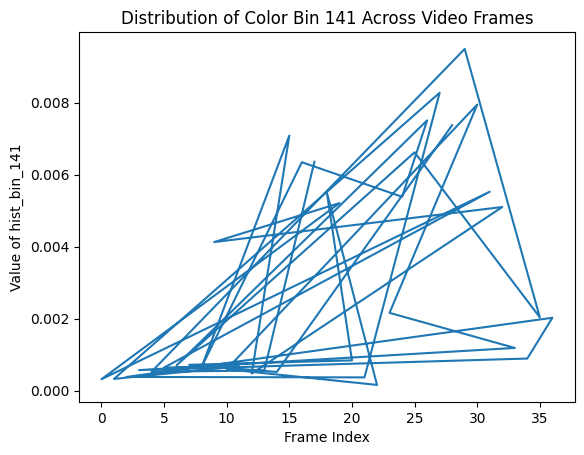

In [18]:
# debug

print(X.columns.to_list())

import matplotlib.pyplot as plt
plt.plot(df['frame_index'], df['hist_bin_141'])
plt.xlabel('Frame Index')
plt.ylabel('Value of hist_bin_141')
plt.title('Distribution of Color Bin 141 Across Video Frames')
plt.show()

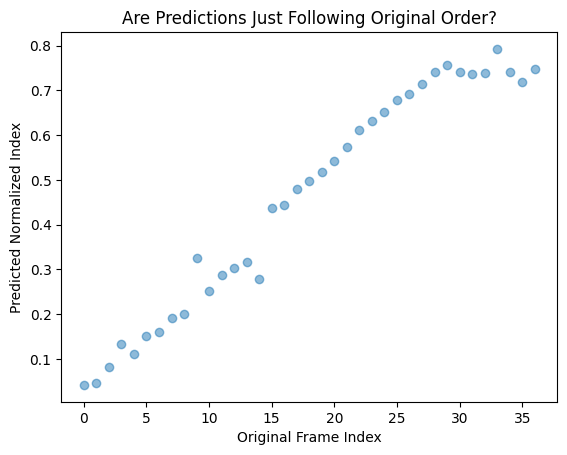

In [19]:
plt.scatter(df['frame_index'], df['predicted_normalized_index'], alpha=0.5)
plt.xlabel("Original Frame Index")
plt.ylabel("Predicted Normalized Index")
plt.title("Are Predictions Just Following Original Order?")
plt.show()
